<a href="https://colab.research.google.com/github/ekaterina533/dataset/blob/main/%D0%94%D0%BE%D0%B1%D1%80%D0%BE_%D0%BF%D0%BE%D0%B6%D0%B0%D0%BB%D0%BE%D0%B2%D0%B0%D1%82%D1%8C_%D0%B2_Colab!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Новый раздел

In [19]:
!pip install scapy dpkt pandas numpy scikit-learn matplotlib

In [35]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import dpkt
import socket
from collections import Counter
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

In [36]:
def download_and_extract_zip():
    # Используем raw-ссылку на архив
    zip_url = "https://github.com/westermo/network-traffic-dataset/raw/main/data/extended/pcaps/right.zip"
    zip_path = "right.zip"
    extract_dir = "right"

    if not os.path.exists(extract_dir):
        print("⬇️ Загрузка ZIP-архива...")
        urlretrieve(zip_url, zip_path)

        print("📦 Распаковка архива...")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print(f"✅ Успешно распаковано {len(zip_ref.namelist())} файлов")
        except zipfile.BadZipFile:
            print("❌ Ошибка: файл не является ZIP-архивом или поврежден")
            return []
        finally:
            if os.path.exists(zip_path):
                os.remove(zip_path)

    pcap_files = [os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith('.pcap')]
    print(f"Найдено {len(pcap_files)} PCAP-файлов")
    return pcap_files

In [27]:
# 2. Парсер PCAP с улучшенной обработкой ошибок
def parse_pcap(file_path):
    packets = []
    with open(file_path, 'rb') as f:
        try:
            pcap = dpkt.pcap.Reader(f)
            for ts, buf in pcap:
                try:
                    eth = dpkt.ethernet.Ethernet(buf)
                    if not isinstance(eth.data, dpkt.ip.IP):
                        continue

                    ip = eth.data
                    transport = ip.data

                    packet = {
                        'timestamp': ts,
                        'src_ip': socket.inet_ntoa(ip.src),
                        'dst_ip': socket.inet_ntoa(ip.dst),
                        'length': ip.len,
                        'ttl': ip.ttl,
                        'protocol': 'other'
                    }

                    if isinstance(transport, dpkt.tcp.TCP):
                        packet.update({
                            'protocol': 'tcp',
                            'src_port': transport.sport,
                            'dst_port': transport.dport,
                            'flags': transport.flags
                        })
                    elif isinstance(transport, dpkt.udp.UDP):
                        packet.update({
                            'protocol': 'udp',
                            'src_port': transport.sport,
                            'dst_port': transport.dport
                        })

                    packets.append(packet)
                except Exception as e:
                    continue
        except Exception as e:
            print(f"⚠️ Ошибка чтения файла {file_path}: {str(e)}")

    return packets

In [28]:
# 3. Оптимизированная предобработка данных
def preprocess_data(packets):
    if not packets:
        return pd.DataFrame(), None, None

    df = pd.DataFrame(packets)

    # Заполнение пропусков
    for col in ['src_port', 'dst_port', 'flags']:
        if col in df.columns:
            df[col] = df[col].fillna(0).astype(int)

    # Кодирование категориальных признаков
    encoders = {}
    for col in ['src_ip', 'dst_ip', 'protocol']:
        if col in df.columns:
            encoders[col] = LabelEncoder()
            df[col] = encoders[col].fit_transform(df[col].astype(str))

    # Нормализация числовых признаков
    numeric_cols = ['length', 'ttl', 'src_port', 'dst_port', 'flags']
    numeric_cols = [col for col in numeric_cols if col in df.columns]

    if numeric_cols:
        scaler = RobustScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df, encoders, scaler

In [29]:
# 4. Визуализация данных
def visualize_analysis(df):
    plt.figure(figsize=(15, 10))

    # Распределение протоколов
    if 'protocol' in df.columns:
        plt.subplot(2, 2, 1)
        df['protocol'].value_counts().plot(kind='bar', color='skyblue')
        plt.title('Protocol Distribution')

    # Распределение длины пакетов
    if 'length' in df.columns:
        plt.subplot(2, 2, 2)
        df['length'].plot(kind='hist', bins=50, color='salmon')
        plt.title('Packet Length Distribution')

    # Топ отправителей
    if 'src_ip' in df.columns:
        plt.subplot(2, 2, 3)
        df['src_ip'].value_counts().head(10).plot(kind='bar', color='lightgreen')
        plt.title('Top 10 Senders')

    plt.tight_layout()
    plt.show()

In [30]:
# 5. Анализ трафика и обнаружение атак
def analyze_traffic(df):
    if df.empty:
        print("No data to analyze")
        return None

    # Создаем метки атак (пример)
    df['is_attack'] = (df['length'] > df['length'].quantile(0.95)).astype(int)
    print("\n🔍 Traffic Class Distribution:")
    print(Counter(df['is_attack']))

    # Обучение модели
    features = df.drop(['timestamp', 'is_attack'], axis=1, errors='ignore')
    model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    model.fit(features)

    # Предсказание аномалий
    df['anomaly'] = model.predict(features)
    attacks = df[df['anomaly'] == -1]

    print(f"\n🚨 Detected {len(attacks)} potential attacks")
    if not attacks.empty:
        print("Sample attack packets:")
        print(attacks[['src_ip', 'dst_ip', 'protocol', 'length']].head(3))

    return model


In [37]:
# Главный блок выполнения
def main():
    print("🔄 Starting PCAP Analysis...")

    # Шаг 1: Загрузка данных
    pcap_files = download_and_extract_zip()
    if not pcap_files:
        print("❌ Не удалось загрузить файлы для анализа")
        return
    # Шаг 2: Парсинг файлов
    all_packets = []
    for pcap_file in pcap_files:
        print(f"\nProcessing {os.path.basename(pcap_file)}...")
        packets = parse_pcap(pcap_file)
        print(f"Extracted {len(packets)} packets")
        all_packets.extend(packets)

    # Шаг 3: Предобработка
    print("\n🧹 Preprocessing data...")
    df, encoders, scaler = preprocess_data(all_packets)

    if df.empty:
        print("❌ No valid data found")
        return

    # Шаг 4: Визуализация
    print("\n📊 Visualizing traffic patterns...")
    visualize_analysis(df)

    # Шаг 5: Анализ
    print("\n🔍 Analyzing traffic for anomalies...")
    model = analyze_traffic(df)

    print("\n✅ Analysis completed successfully!")


🔄 Starting PCAP Analysis...
⬇️ Загрузка ZIP-архива...
📦 Распаковка архива...
✅ Успешно распаковано 1 файлов
Найдено 1 PCAP-файлов

Processing right.pcap...
Extracted 22902 packets

🧹 Preprocessing data...

📊 Visualizing traffic patterns...


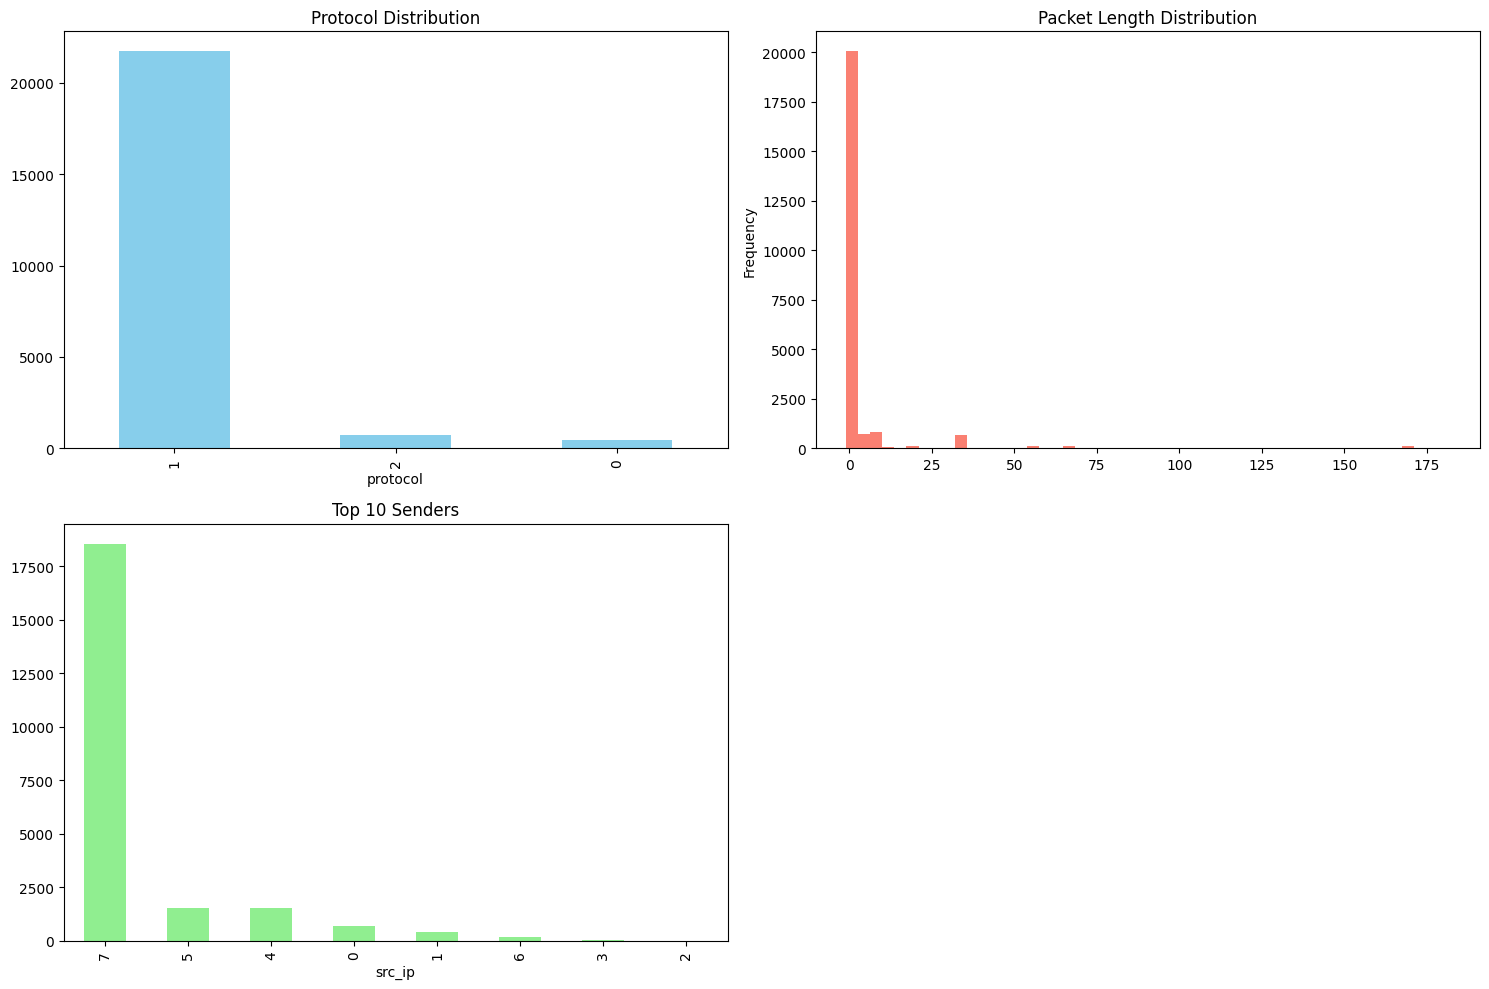


🔍 Analyzing traffic for anomalies...

🔍 Traffic Class Distribution:
Counter({0: 21768, 1: 1134})

🚨 Detected 741 potential attacks
Sample attack packets:
   src_ip  dst_ip  protocol  length
0       1       8         0    -1.0
2       1       8         0    -1.0
4       1       8         0    -1.0

✅ Analysis completed successfully!


In [38]:
# Запуск анализа
if __name__ == "__main__":
    main()